### reference: https://github.com/juho-lee/bnp/blob/master/regression/lotka_volterra.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import time 
import random


In [2]:
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
figsiz_=(11,2.5*2)
fontsiz = 18
plt.rc('figure', figsize=figsiz_,dpi=100)
plt.rcParams['figure.figsize'] = figsiz_
plt.rc('font', family='serif', size=fontsiz)

In [4]:
import torch
import numpy as np
import numpy.random as npr
import numba as nb
from tqdm import tqdm
from attrdict import AttrDict
import wget
import os.path as osp



def load_hare_lynx(num_batches, batch_size,num_ctx=10,num_channels=2,mode='easy', datasets_path='./',forscore=True):
    filename = osp.join(datasets_path, 'lotka_volterra', 'LynxHare.txt')
    if not osp.isfile(filename):
        wget.download('http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt',out=osp.join(datasets_path, 'lotka_volterra'))

    tb = np.loadtxt(filename)
    times = torch.Tensor(tb[:,0]).unsqueeze(-1)
    pops = torch.stack([torch.Tensor(tb[:,2]), torch.Tensor(tb[:,1])], -1)

    batches = []
    N = pops.shape[-2]
    epoch_start = time.time()    
    for _ in range(num_batches):
        batch = AttrDict()

        #if num_ctx is None:
        #num_ctx = torch.randint(low=15, high=N-15, size=[1]).item() #original            
        num_tar = N - num_ctx


        idxs = torch.rand(batch_size, N).argsort(-1)
        batch.x = torch.gather(torch.stack([times]*batch_size),-2, idxs.unsqueeze(-1)).repeat(1,1,2)        
        batch.y = torch.gather(torch.stack([pops]*batch_size),-2, torch.stack([idxs]*2, -1))
        
        if mode == 'easy':
            
            batch.xc = batch.x[:,:num_ctx]
            batch.yc = batch.y[:,:num_ctx]
            
            if forscore:
                batch.xt = batch.x[:,0:]
                batch.yt = batch.y[:,0:]
            else:
                batch.xt = batch.x[:,num_ctx:]
                batch.yt = batch.y[:,num_ctx:]

        
        if mode == 'hard':
            #idxs.shape
            
            xc_list = []
            yc_list = []
            xt_list = []
            yt_list = []

            for ch in range(num_channels):
                idxs = torch.rand(batch_size, N).argsort(-1)    
                x_ = torch.gather(batch.x[:,:,ch],-1, idxs )
                y_ = torch.gather(batch.y[:,:,ch],-1, idxs )    

                xc_list.append(x_[:,:num_ctx].unsqueeze(dim=-1))
                yc_list.append(y_[:,:num_ctx].unsqueeze(dim=-1))
                
                if forscore:
                    xt_list.append(x_[:,0:].unsqueeze(dim=-1))
                    yt_list.append(y_[:,0:].unsqueeze(dim=-1))    
                else:
                    xt_list.append(x_[:,num_ctx:].unsqueeze(dim=-1))
                    yt_list.append(y_[:,num_ctx:].unsqueeze(dim=-1))    
                

                
            batch.xc = torch.cat(xc_list,dim=-1)
            batch.xt = torch.cat(xt_list,dim=-1)
            batch.yc = torch.cat(yc_list,dim=-1)
            batch.yt = torch.cat(yt_list,dim=-1)

        batch = standardize(batch)            
        batches.append(batch)
    return batches



def standardize(batch):
    with torch.no_grad():
        mu, sigma = batch.xc.mean(-2, keepdim=True), batch.xc.std(-2, keepdim=True)
        sigma[sigma==0] = 1.0
        #batch.x = (batch.x - mu) / (sigma + 1e-5)
        batch.xc = (batch.xc - mu) / (sigma + 1e-5)
        batch.xt = (batch.xt - mu) / (sigma + 1e-5)
        batch.xmu = mu
        batch.xstd = sigma

        mu, sigma = batch.yc.mean(-2, keepdim=True), batch.yc.std(-2, keepdim=True)
        #batch.y = (batch.y - mu) / (sigma + 1e-5)
        batch.yc = (batch.yc - mu) / (sigma + 1e-5)
        batch.yt = (batch.yt - mu) / (sigma + 1e-5)
        batch.ymu = mu
        batch.ystd = sigma
        
        return batch



# train models

In [5]:
from models.test_baseline import Convcnp,compute_loss_baseline
from models.test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
from models.test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  
from models.test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  

 

num_channels = 2
nsamples_latent=10
nsamples_gp = 10
cnntype = 'shallow'

lr = 1e-3
weight_decay=1e-4
init_lengthscale = 0.1

#def get_model(modelname='gp'):        
def get_model(modelname='gpdep',cnntype='deep'):        
    
    if modelname == 'base':
        model = Convcnp(in_dims=1,out_dims=1,num_channels=num_channels,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baseline

    if modelname == 'baselatent':
        model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_latent,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baselinelatent
        
    if modelname == 'gpind':        
        model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_gp,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
    if modelname == 'gpdep':        
        model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_gp,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
    return model,opt,lossfun


def merge_allset_1d(xc,yc,xt,yt):
    xct = torch.cat([xc,xt],dim=1)
    yct = torch.cat([yc,yt],dim=1)
    xct,s_idx =torch.sort(xct,dim=1)

    if len(xc.size()) == 3:
        yct = torch.gather(yct,1,s_idx)    
    if len(xc.size()) == 4:
        yct = torch.gather(yct,1,s_idx[:,:,0,:])
    return xct,yct
    

    
    

proposed_model_list = ['gpind','gpdep']
def validate_epochs_pair(dataset_pair,model,lossfun):
    model.eval()
    likelihoods = []
        
    for ith_pair in dataset_pair:                
        context_x,context_y,target_x,target_y = ith_pair.xc,ith_pair.yc,ith_pair.xt,ith_pair.yt        
        nobs = target_x.size(1)
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)
            
        outs = model(context_x.cuda(),context_y.cuda(),target_x.cuda())        
        obj = -lossfun( outs.pymu, outs.pystd, target_y.cuda(),intrain=False)
                    
        likelihoods.append(obj.cpu().data.numpy())        
        
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll    


## load saved model paramlist

In [6]:
runv,cnntype=14,'shallow'


saved_modelparam_path3 = './params/param_predpray/gpdep_{}_nepochs100_initl0.1_gppriorscale1.0_runv{}_mixture4.pth'.format(cnntype,runv) 
saved_modelparam_path_list = [saved_modelparam_path3]



# prediction for two task

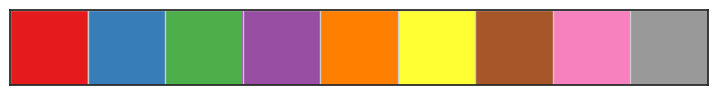

In [7]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')

current_palette = sns.color_palette(sns.hls_palette(4+1, l=.5, s=0.8))
current_palette = sns.color_palette('Set1')


sns.palplot(current_palette)


In [8]:
#num_channels


In [8]:
datav=1
nb=2
#num_ctx = 10
num_ctx = 40
#num_ctx = 70
mode = 'easy' if datav == 1 else 'hard'

#eval_data = load_hare_lynx(1, nb, mode=mode ,num_ctx=num_ctx , datasets_path='./realdata_predpray/',forscore=False)
eval_data = load_hare_lynx(1, nb, mode=mode ,num_ctx=num_ctx , datasets_path='./download/realdata_predpray/',forscore=False)




nfull=200
idx=0

scale_xmu,scale_xstd=eval_data[idx].xmu.cpu().data.numpy(),eval_data[idx].xstd.cpu().data.numpy()
scale_ymu,scale_ystd=eval_data[idx].ymu.cpu().data.numpy(),eval_data[idx].ystd.cpu().data.numpy()
context_x,context_y,target_x,target_y  = eval_data[idx].xc,eval_data[idx].yc,eval_data[idx].xt,eval_data[idx].yt

pred_xlb,pred_xub = torch.cat([context_x,target_x],dim=1).min().item()-0.1,torch.cat([context_x,target_x],dim=1).max().item()+0.1
full_x = torch.linspace(pred_xlb,pred_xub,nfull)[None,:].repeat(num_channels,1).T
full_x = full_x[None,:,:].repeat(nb,1,1)

print('context_x.shape,context_y.shape,target_x.shape,target_y.shape,full_x.shape')
print(context_x.shape,context_y.shape,target_x.shape,target_y.shape,full_x.shape)


context_x.shape,context_y.shape,target_x.shape,target_y.shape,full_x.shape
torch.Size([2, 40, 2]) torch.Size([2, 40, 2]) torch.Size([2, 51, 2]) torch.Size([2, 51, 2]) torch.Size([2, 200, 2])


In [9]:
#rypmu.shape
#rxf.shape

figsiz_ = (10,6)
#bidx=4
wspace_ = 0.5
hspace_ = 0.25
fontsiz_ = 14
alpha_=0.15


pred_xlb,pred_xub = torch.cat([context_x,target_x],dim=1).min().item()-0.1,torch.cat([context_x,target_x],dim=1).max().item()+0.1
xlim_ = [pred_xlb,pred_xub]
cols = ['pray','predator']


delta_x=1
xlim_ = [1840-delta_x,1940+delta_x]
ylim_ = [[-20,130],[-20,240]]

In [10]:
proposed_model_list

['gpind', 'gpdep']

In [11]:
modelname_dict ={'base':'convcnp','gpind':'GPconvcnp','gpdep':'proposed'}

In [12]:
datatype='real_predprayset'

In [13]:
num_samples=5

spikeslab version 7 with tempering 0.1
<All keys matched successfully>
----------------------------------------------------------------------------------------------------
loaded_param: ./params/param_predpray/gpdep_shallow_nepochs100_initl0.1_gppriorscale1.0_runv14_mixture4.pth
modelname: proposed with task: 0
xc.shape: (40, 2), yc.shape: (40, 2), xc.shape: (51, 2), yt.shape: (51, 2)
----------------------------------------------------------------------------------------------------


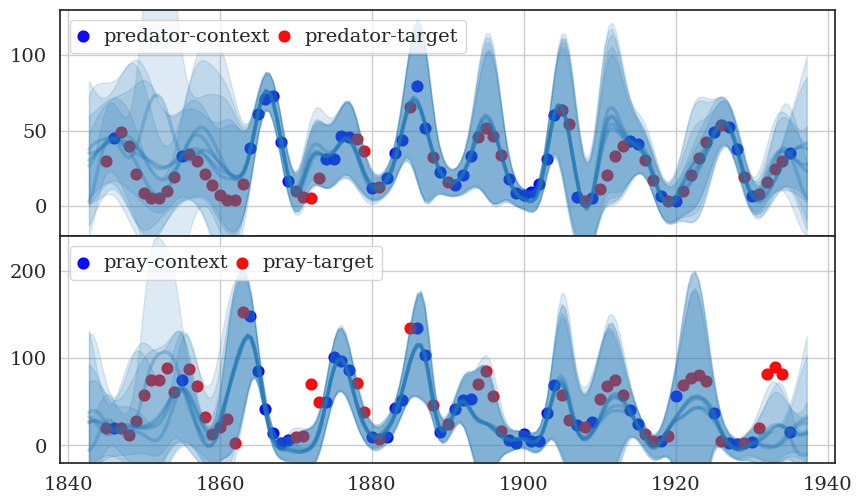

----------------------------------------------------------------------------------------------------
loaded_param: ./params/param_predpray/gpdep_shallow_nepochs100_initl0.1_gppriorscale1.0_runv14_mixture4.pth
modelname: proposed with task: 1
xc.shape: (40, 2), yc.shape: (40, 2), xc.shape: (51, 2), yt.shape: (51, 2)
----------------------------------------------------------------------------------------------------


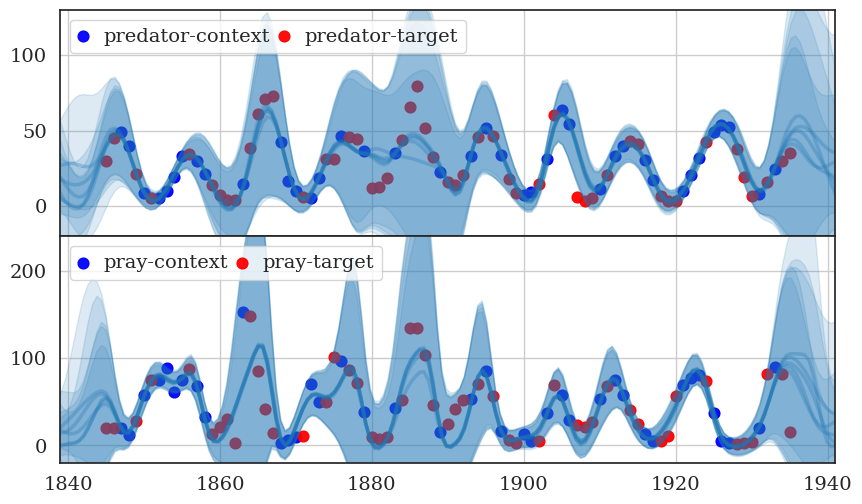

In [14]:
for saved_modelparam_path in saved_modelparam_path_list:
    
    modelspec =  saved_modelparam_path.split('/')[-1][:-4]
    modelname = saved_modelparam_path.split('/')[-1].split('_')[0]
    cnntype = saved_modelparam_path.split('/')[-1].split('_')[1]

    #model,_ = build_model(model_type=model_type)
    model,_,lossfun = get_model(modelname=modelname,cnntype=cnntype)
    if model.modelname in ['gpdep','gpind']:
        model.num_samples=num_samples
    #if model.modelname in ['base']:
    else:
        model.num_samples=1
    
    load_dict = torch.load(saved_modelparam_path)
    print(model.load_state_dict(load_dict['state_dict']) )  
    
    
    #predict
    if model.modelname in proposed_model_list and len(context_x.size()) == 3:        
        context_x_,target_x_,full_x_ =context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2),full_x.unsqueeze(dim=-2)                
    else:
        context_x_,target_x_,full_x_ = context_x,target_x,full_x
    model.eval()
    outs = model(context_x_.cuda(),context_y.cuda(),full_x_.cuda())
    y_mean, y_std = outs.pymu,outs.pystd    
    y_mean = y_mean.squeeze().cpu().data.numpy()
    y_std = y_std.squeeze().cpu().data.numpy()
    
    if model.modelname in ['base']:  
        rypmu=  scale_ymu + y_mean*scale_ystd
        rypstd=  y_std*scale_ystd   
    else:
        rypmu=  scale_ymu[None,:,:,:] + y_mean*scale_ystd[None,:,:,:]
        rypstd=  y_std*scale_ystd[None,:,:,:]   
    

    context_x__ = context_x_.squeeze().cpu().data.numpy()
    target_x__ = target_x_.squeeze().cpu().data.numpy()
    full_x__ = full_x_.squeeze().cpu().data.numpy()

    context_y__ = context_y.squeeze().cpu().data.numpy()
    target_y__ = target_y.squeeze().cpu().data.numpy()

    
    rxc,rxt=context_x__*scale_xstd + scale_xmu ,  target_x__*scale_xstd + scale_xmu
    ryc,ryt=context_y__*scale_ystd + scale_ymu ,  target_y__*scale_ystd + scale_ymu
    rxf=full_x__*scale_xstd + scale_xmu
    
    
    
    
    
    for ifig in range(2):
        print('-'*100)
        print('loaded_param: {}'.format(saved_modelparam_path))
        print('modelname: {} with task: {}'.format(modelname_dict[model.modelname],ifig))
        print('xc.shape: {}, yc.shape: {}, xc.shape: {}, yt.shape: {}'.format(rxc[ifig,:,:].shape,ryc[ifig,:,:].shape,rxt[ifig,:,:].shape,ryt[ifig,:,:].shape ))
        print('-'*100)        
        
        
        _, axs = plt.subplots(figsize=figsiz_, nrows=2, sharex=True)
        plt.subplots_adjust(wspace= 0.0, hspace= 0.0)
        for j in range(num_channels):
            if j==0:
                axs[j].scatter(rxc[ifig,:,j],ryc[ifig,:,j],color = [0,0,1],label = 'predator-context',s=60,alpha=0.95)
                axs[j].scatter(rxt[ifig,:,j],ryt[ifig,:,j],color = [1,0,0],label = 'predator-target',s=60,alpha=0.95)
            else:
                axs[j].scatter(rxc[ifig,:,j],ryc[ifig,:,j],color = [0,0,1],label = 'pray-context',s=60,alpha=0.95)
                axs[j].scatter(rxt[ifig,:,j],ryt[ifig,:,j],color = [1,0,0],label = 'pray-target',s=60,alpha=0.95)


            if model.modelname in ['base']: 
                axs[j].plot(rxf[ifig,:,j],rypmu[ifig,:,j],color='tab:blue',linewidth=2.5 , alpha=4*alpha_)
                axs[j].fill_between(rxf[ifig,:,j],
                                 rypmu[ifig,:,j] + 2 * rypstd[ifig,:,j],
                                 rypmu[ifig,:,j] - 2 * rypstd[ifig,:,j],
                                 color='tab:blue', alpha=2*alpha_)


            else:
                for kk in range(num_samples):
                    axs[j].plot(rxf[ifig,:,j],rypmu[kk,ifig,:,j],color='tab:blue',linewidth=2.5 , alpha=2*alpha_)
                    axs[j].fill_between(rxf[ifig,:,j],
                                    rypmu[kk,ifig,:,j] + 2 * rypstd[kk,ifig,:,j],
                                    rypmu[kk,ifig,:,j] - 2 * rypstd[kk,ifig,:,j],
                                    color='tab:blue', alpha=alpha_)



            axs[j].xaxis.set_tick_params(labelsize=fontsiz_)
            axs[j].yaxis.set_tick_params(labelsize=fontsiz_)
            axs[j].set_xlim(xlim_)
            axs[j].set_ylim(ylim_[j])
            axs[j].legend(loc='upper left',fontsize=fontsiz_,ncol=4,labelspacing=1.0,handlelength=0.5,columnspacing=0.5)

            #if j == 0:
            #    print('{}'.format(saved_modelparam_path.split('/')[-1][:-20]))

        #savefigname = './' + '{}_{}_datav{}_runv{}_ncontext{}_nsample{}_fig{}'.format(datatype,model.modelname,datav,runv,num_ctx, model.num_samples,ifig) 
        #plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
        #print('savefigname: {}'.format(savefigname))
        plt.show()
    print('\n\n')
    